In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

KEY_STATE, KEY_COUNTRY = "Province_State", "Country_Region"

def get_df(date):
    base = date - timedelta(days=1)
    d = base.strftime("%m-%d-%Y")
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv"
    s = requests.get(url.format(d)).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))
    country_key = KEY_COUNTRY if (KEY_COUNTRY in df.columns) else KEY_COUNTRY.replace("_", "/")
    country_replace = lambda x: "United States" if x == "US" else x
    # TODO: Fix "Korea, South"
    df[country_key] = df[country_key].map(country_replace)
    return (base, df)

def get_counts(df):
    if KEY_STATE in df.columns:
        key_state, key_us = KEY_STATE, KEY_COUNTRY
    else:
        key_state, key_us = KEY_STATE.replace("_", "/"), KEY_COUNTRY.replace("_", "/")
    ca_mask, ny_mask, us_mask = df[key_state] == STATE1, df[key_state] == STATE2, df[key_us] == "United States"
    return [df[ca_mask]["Confirmed"].sum(), df[ny_mask]["Confirmed"].sum(), df[us_mask]["Confirmed"].sum()]

def get_perc(c):
    # ca1, ny1, us1, ca2, ny2, us2 = c
    percentages = [(c[3] - c[0]) / c[0], (c[4] - c[1]) / c[1], (c[5] - c[2]) / c[2]]
    return [round(100 * x, 2) for x in percentages]

def get_df_list(month, day, past):
    date_list = [datetime(2020, month, day) - timedelta(days=x) for x in range(past)]
    return [get_df(date) for date in date_list]

def get_data(df_list):
    date_counts, date_percs = [], []
    for date, df in df_list:
        c = get_counts(df)
        date_counts.append((date, [c[0], c[1], c[2]]))
    for i in range(len(date_counts) - 1, 0, -1):
        perc = get_perc(date_counts[i][1] + date_counts[i - 1][1])
        date_percs.append((date_counts[i-1][0], perc))
    state1 = [p[1][0] for p in date_percs], [c[1][0] for c in date_counts[1:]]
    state2 = [p[1][1] for p in date_percs], [c[1][1] for c in date_counts[1:]]
    us = [p[1][2] for p in date_percs], [c[1][2] for c in date_counts[1:]]
    return state1, state2, us

def perc_count_pairs(time_data, y_data):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8))
    zipped = [[(ax1, p), (ax2, c)] for (p, c) in y_data]
    for (ax1, y1), (ax2, y2) in zipped:
        delta = timedelta(days=1)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))        
        ax1.set_xlim([min(time_data) - delta, max(time_data) + delta])
        ax1.plot_date(time_data, y1);
        ax1.set_ylabel(f"Daily % Increase")
        ax2.set_ylabel(f"Number of Cases")
        ax2.plot_date(time_data, y2);
        legend = (f"{STATE1}", f"{STATE2}", "United States")
        ax1.legend(legend)
        ax2.legend(legend)

In [3]:
# get_df(datetime(2020, 3, 30))[1]

In [4]:
gis_data = get_df_list(4, 7, 23)
time_data = [date for date, _ in gis_data[0:-1:]]

In [100]:
gis_data.insert(0, get_df(datetime(2020, 4, 8)))
# gis_data.append(get_df(datetime(2020, 3, 15)))
# gis_data.pop()
time_data = [date for date, _ in gis_data[0:-1:]]

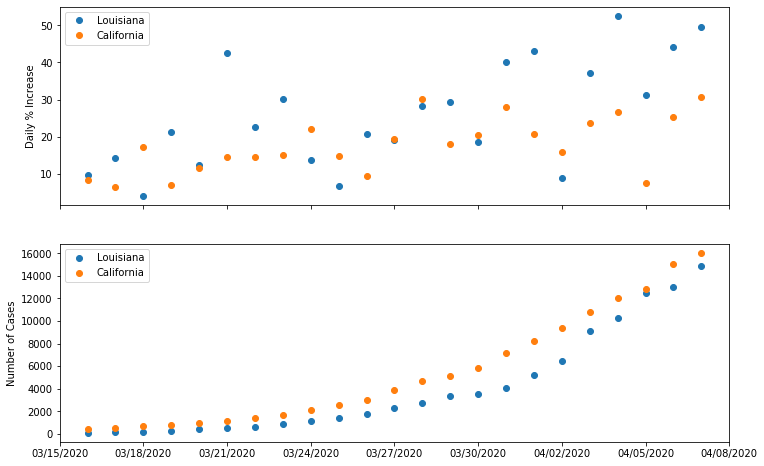

In [101]:
STATE1 = "Louisiana"
STATE2 = "California"
y_data = get_data(gis_data)
perc_count_pairs(time_data, y_data[:-1])

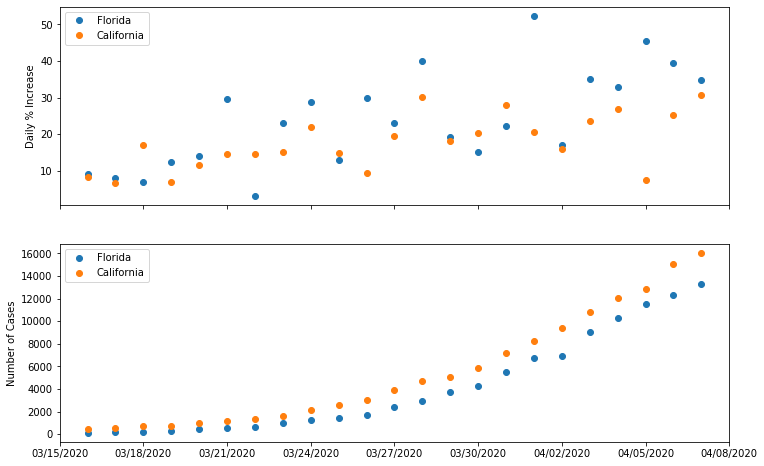

In [102]:
STATE1 = "Florida"
STATE2 = "California"
y_data = get_data(gis_data)
perc_count_pairs(time_data, y_data[:-1])

# Get state per capita data

In [103]:
def get_all_states(df):
    all_states = list(set(df[df["Country_Region"] == "United States"]["Province_State"]))
    all_states.remove("Diamond Princess")
    all_states.remove("Grand Princess")
    all_states.remove("Guam")
    all_states.remove("Northern Mariana Islands")
    all_states.remove("Recovered")
    all_states.remove("Virgin Islands")
    all_states.remove("Puerto Rico")
    all_states.remove("District of Columbia")
    df_pop = pd.read_csv("data/nst-est2019-alldata.csv")
    df_pop = df_pop[df_pop.NAME.isin(all_states)]
    state_pop = dict(df_pop[["NAME", "POPESTIMATE2018"]].values)
    return all_states, state_pop

def group_per_df(gis_data):
    grouped_state_df_list = []
    for date, df in gis_data:
        key = KEY_STATE if KEY_STATE in df.columns else KEY_STATE.replace("_", "/")
        state_df = df[df[key].isin(all_states)]
        grouped_state_df = state_df[[key, "Confirmed"]].groupby(key).sum().reset_index()
        grouped_state_df["population"] = [state_pop[x] for x in grouped_state_df[key]]
        grouped_state_df["percentage"] = round(1000000 * grouped_state_df["Confirmed"] / grouped_state_df["population"], 3)
        grouped_state_df["1_in_x"] = round(grouped_state_df["population"] / grouped_state_df["Confirmed"])
        grouped_state_df.sort_values(by="percentage", ascending=False, inplace=True)
        grouped_state_df_list.append((date, grouped_state_df))
    return grouped_state_df_list

def get_csv(grouped_state_df_list, all_states, metric="percentage"):
    N = len(grouped_state_df_list)
    all_dates = [grouped_state_df_list[i][0].strftime("%B %d") for i in range(N)]
    count_dict = [{"state": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    state_dict = {s: {"state": s} for s in all_states}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in state_dict.values()]

    for i in range(N):
        date_string = grouped_state_df_list[i][0].strftime("%B %d")
        key = KEY_STATE if (KEY_STATE in grouped_state_df_list[i][1].columns) else KEY_STATE.replace("_", "/")
        df_temp = grouped_state_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for state, count in data_list:
            state_dict[state][date_string] = count
    return state_dict

def save_csv(my_dict, metric="rate"):
    my_df = pd.DataFrame(my_dict.values())
    base_flag_url = 'https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/images/flags/{state_name}-large.png'
    my_df['url'] = [base_flag_url.format(state_name=state.replace(" ", "-").lower()) for state in all_states]
    my_df.to_csv(r'{metric}_data.csv'.format(metric=metric), index=False)
    print(f"saved to {metric}_data.csv")

all_states, state_pop = get_all_states(gis_data[0][1])
grouped_state_df_list = group_per_df(gis_data)
perc_dict = get_csv(grouped_state_df_list, all_states, "percentage")
save_csv(perc_dict, "rate")
count_dict = get_csv(grouped_state_df_list, all_states, "Confirmed")
save_csv(count_dict, "count")

saved to rate_data.csv
saved to count_data.csv


# Country cases per capita

In [112]:
gis_data[0][1]['Country_Region']

def get_all_countries(df):
    all_countries = set(gis_data[0][1]['Country_Region'])
    df_pop = pd.read_csv("data/prb-2019.csv")
    df_pop = df_pop.loc[df_pop["Type"] == "Country"][["FIPS", "Name", "Data"]]
    # make country code dict to get two letter codes; e.g. US, CA, etc.
    # https://github.com/google/region-flags/tree/gh-pages/png
    url = "https://raw.githubusercontent.com/google/region-flags/gh-pages/png/{code}.png"
    df_pop["url"] = [url.format(code=c) for c in df_pop["FIPS"].values]
    df_pop.drop(["FIPS"], axis=1, inplace=True)
    df_pop = df_pop[["Name", "url", "Data"]]
    df_pop.columns = ["country", "url", "data"]
    df_pop.sort_values(by="data", inplace=True)
    df_pop = df_pop[df_pop["data"] >= 1]
    world_countries = set(df_pop["country"].unique())
    both = world_countries.intersection(all_countries)
    df_pop = df_pop[df_pop["country"].isin(both)]
    world_pop = dict(df_pop[["country", "data"]].values)
    country_url = dict(df_pop[df_pop["country"].isin(both)][["country", "url"]].values)
    return both, world_pop, country_url

def group_per_df_country(gis_data):
    all_countries, world_pop, country_url = get_all_countries(gis_data[0][1])
    grouped_country_df_list = []
    for date, df in gis_data:
        key = KEY_COUNTRY if KEY_COUNTRY in df.columns else KEY_COUNTRY.replace("_", "/")
        country_df = df[df[key].isin(all_countries)]
        grouped_country_df = country_df[[key, "Confirmed"]].groupby(key).sum().reset_index()
        grouped_country_df["population"] = [int(world_pop[x] * 1000000) for x in grouped_country_df[key]]
        grouped_country_df["capita"] = round(1000000 * grouped_country_df["Confirmed"] / grouped_country_df["population"], 3)
        grouped_country_df.sort_values(by="capita", ascending=False, inplace=True)
        grouped_country_df["url"] = [country_url[country] for country in grouped_country_df[key]]
        grouped_country_df_list.append((date, grouped_country_df))
    return grouped_country_df_list, all_countries, country_url

def get_csv(grouped_country_df_list, all_countries, country_url, metric="capita"):
    N = len(grouped_country_df_list)
    all_dates = [grouped_country_df_list[i][0].strftime("%B %d") for i in range(N)]
    count_dict = [{"country": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    country_dict = {c: {"country": c, "url": u} for c, u in country_url.items()}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in country_dict.values()]

    for i in range(N):
        date_string = grouped_country_df_list[i][0].strftime("%B %d")
        key = KEY_COUNTRY if (KEY_COUNTRY in grouped_country_df_list[i][1].columns) else KEY_COUNTRY.replace("_", "/")
        df_temp = grouped_country_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for country, count in data_list:
            country_dict[country][date_string] = count
    return country_dict

def save_csv(my_dict, metric="capita"):
    my_df = pd.DataFrame(my_dict.values())
    my_df.to_csv(r'{metric}_country_data.csv'.format(metric=metric), index=False)
    print(f"saved to {metric}_country_data.csv")

grouped_country_df_list, all_countries, country_url = group_per_df_country(gis_data)
metric = "capita"
country_dict = get_csv(grouped_country_df_list, all_countries, country_url, metric)
country_dict.pop('China')
save_csv(country_dict, metric)

saved to capita_country_data.csv


In [114]:
metric = "Confirmed"
count_country_dict = get_csv(grouped_country_df_list, all_countries, country_url, 'Confirmed')
count_country_dict.pop('China')
save_csv(count_country_dict, "Confirmed")

saved to Confirmed_country_data.csv
